# Water-bridge Interactions

This tutorial showcases how to use ProLIF to generate an interaction fingerprint inlcuding the water bridge interactions and analyze the water bridge interactions for a ligand-protein complex

## Preparation

Let's start by importing MDAnalysis and ProLIF to read our tutorial files and create selections for the ligand, protein and water.

:::{important}
It is advised to select for the protein and water selection only the residues in close distance to the ligand,
else the generation of the fingerprint will be time consuming due to the amount of analyzed atoms.
:::

For the selection of the protein in this tutorial we only select the resiudes around 15.0 Å of the ligand.

:::{tip}
For the water selection it is possible to update the `AtomGroup`, which is convinient with 
the movement of the water molecules during the simulations.
:::

For the water selection we select the water residues around 4 Å of the ligand.

In [1]:
import MDAnalysis as mda
import prolif as plf

# load topology and trajectory
u = mda.Universe(plf.datafiles.WATER_TOP, plf.datafiles.WATER_TRAJ)

# create selections for the ligand and protein
ligand_selection = u.select_atoms("resname QNB")
protein_selection = u.select_atoms(
    "protein and byres around 15.0 group ligand",
    ligand=ligand_selection,
)
water_selection = u.select_atoms(
    "segid WAT and byres around 4 (group ligand or group pocket)",
    ligand=ligand_selection,
    pocket=protein_selection,
    updating=True,
)
ligand_selection, protein_selection, water_selection

C:\Users\talag\anaconda3\envs\prolif_312\Lib\site-packages\MDAnalysis\topology\tables.py:52: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.topology.tables has been moved to MDAnalysis.guesser.tables. This import point will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning)


(<AtomGroup with 49 atoms>,
 <AtomGroup with 2516 atoms>,
 <AtomGroup with 69 atoms, with selection 'segid WAT and byres around 4 (group ligand or group pocket)' on the entire Universe.>)

Now we perform the calculation of the interactions.
In this tutorial we only focus on the water bridge interactions and we look at the water bridges of the orders 1, 2 and 3. For this we select for the order "3".

In [2]:
fp = plf.Fingerprint(["WaterBridge"], parameters={"WaterBridge": {"water": water_selection, "order": 3}})

In [3]:
fp.run(u.trajectory, ligand_selection, protein_selection)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 1 interactions: ['WaterBridge'] at 0x1ba81777cb0>

## Visualization

The trajectory that we use consists out of 20 frames. let's analyze the water bridge interactions that are present in the trajectory. For this we generate a DataFrame, which shows what interactions occur during each frame of the simulation.

In [4]:
df = fp.to_dataframe()
df

ligand           QNB1.X                                                  \
protein        ASP103.X    THR399.X    TRP400.X    TYR403.X    CYS429.X   
interaction WaterBridge WaterBridge WaterBridge WaterBridge WaterBridge   
Frame                                                                     
0                 False        True        True        True       False   
1                 False       False        True       False        True   
2                  True       False       False       False       False   
3                 False       False       False       False       False   
4                 False       False        True       False       False   
5                 False       False       False       False       False   
6                 False       False       False       False       False   
7                 False       False        True       False        True   
8                 False       False       False       False       False   
9                 False       False       False       False       False   
10                False       False        True       False       False   
11                False       False        True       False       False   
12                False       False        True       False       False   
13                False       False        True       False       False   
14                False       False       False       False       False   
15                False       False       False       False       False   
16                False       False        True       False        True   
17                False       False        True       False       False   
18                False       False       False       False       False   
19                False       False       False       False       False   

ligand                   
protein        SER433.X  
interaction WaterBridge  
Frame                    
0                 False  
1                 False  
2                  True  
3                 False  
4                 False  
5                 False  
6                 False  
7                 False  
8                 False  
9                 False  
10                False  
11                False  
12                False  
13                False  
14                False  
15                False  
16                False  
17                False  
18                False  
19                False

We now sort the values to identify which of the water bridge interactions appeares more frequent than the others.

In [5]:
# percentage of the trajectory where each interaction is present
df.mean().sort_values(ascending=False).to_frame(name="%").T * 100

ligand           QNB1.X                                                  \
protein        TRP400.X    CYS429.X    ASP103.X    THR399.X    TYR403.X   
interaction WaterBridge WaterBridge WaterBridge WaterBridge WaterBridge   
%                  50.0        15.0         5.0         5.0         5.0   

ligand                   
protein        SER433.X  
interaction WaterBridge  
%                   5.0

We can also analyze the water bridge interactions using the barcode.

<Axes: xlabel='Frame'>

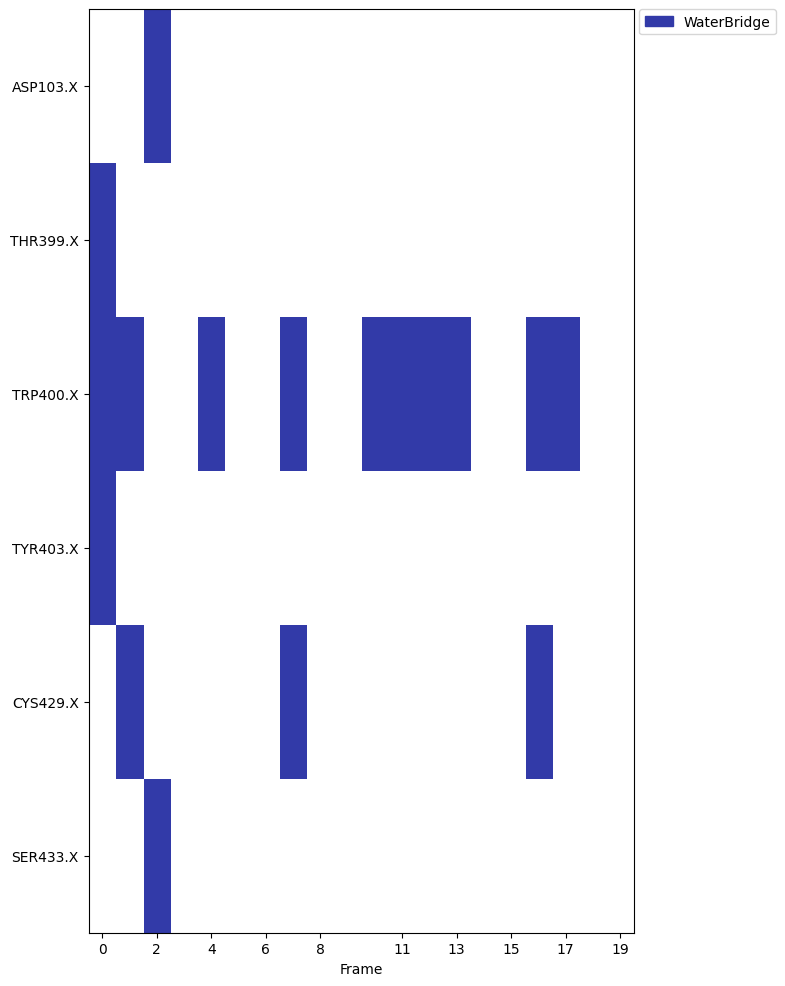

In [6]:
fp.plot_barcode()

The water bridge interactions are also present in the ligand network visualization.
Here we can also see the water bridges with higher orders, where the water molecules interact 
with each other thus building water bridges.

:::{tip}
The threshold for interactions to be displayed in `fp.plot_lignetwork()` is `0.3`. Thus only interactions with an occurence of more than 30 % will appear with the default settings, so don't forget to adjust the threshold if you want to see interactions with lower occurence.
:::

In [7]:
ligand_mol = plf.Molecule.from_mda(ligand_selection)
view = fp.plot_lignetwork(ligand_mol, threshold=0.05)
view

## Water Bridge Interaction Metadata

The current example showed if certain water bridge interactions are present or not during the simulation.
During the interaction calculation metadata is stored, which we can use to obtain more information about the interaction.

Here we show how to access the metadata stored after the calculcation of the interactions.
We will access all of the metadata stored and display it as a Dataframe.

In [8]:
import pandas as pd

all_metadata = []

for frame, dict in fp.ifp.items():
    for (lig_resid, prot_resid), interaction_dict in dict.items():
        for metadata in interaction_dict["WaterBridge"]:
            flat = {
                "frame": frame,
                "ligand_residue": lig_resid,
                "protein_residue": prot_resid,
                "order": metadata.get("order"),
                "distance": metadata.get("distance"),
                "ligand_role": metadata.get("ligand_role"),
                "protein_role": metadata.get("protein_role"),
                "water_residues": metadata.get("water_residues"),
            }
            all_metadata.append(flat)

df_metadata = pd.DataFrame(all_metadata)

:::{important} We can see that the metadata contains important information about the interactions calculated, containing the `order` of the water bridge interactions, which `water_residues` participate in the water bridge interactions as well as the `ligand_role` and the `protein_role` during the interactions. :::

In [9]:
df_metadata

,frame,ligand_residue,protein_residue,order,distance,ligand_role,protein_role,water_residues
0,0,QNB1.X,TRP400.X,1,5.394578,HBAcceptor,HBAcceptor,"(TIP383.X,)"
1,0,QNB1.X,TYR403.X,2,8.791619,HBAcceptor,HBDonor,"(TIP383.X, TIP317.X)"
2,0,QNB1.X,THR399.X,2,8.450708,HBAcceptor,HBAcceptor,"(TIP383.X, TIP317.X)"
3,1,QNB1.X,CYS429.X,1,6.379684,HBAcceptor,HBDonor,"(TIP383.X,)"
4,1,QNB1.X,TRP400.X,1,6.063980,HBAcceptor,HBAcceptor,"(TIP383.X,)"
5,2,QNB1.X,ASP103.X,1,5.978124,HBDonor,HBAcceptor,"(TIP390.X,)"
6,2,QNB1.X,SER433.X,3,11.927196,HBDonor,HBAcceptor,"(TIP390.X, TIP393.X, TIP357.X)"
7,4,QNB1.X,TRP400.X,1,6.092165,HBAcceptor,HBAcceptor,"(TIP383.X,)"
8,7,QNB1.X,CYS429.X,1,6.179404,HBAcceptor,HBDonor,"(TIP383.X,)"
9,7,QNB1.X,TRP400.X,1,5.477529,HBAcceptor,HBAcceptor,"(TIP383.X,)"


We can now use this information to access interactions of orders 2 and 3.

In [10]:
higher_order_df = df_metadata[df_metadata["order"].isin([2, 3])]
higher_order_df

,frame,ligand_residue,protein_residue,order,distance,ligand_role,protein_role,water_residues
1,0,QNB1.X,TYR403.X,2,8.791619,HBAcceptor,HBDonor,"(TIP383.X, TIP317.X)"
2,0,QNB1.X,THR399.X,2,8.450708,HBAcceptor,HBAcceptor,"(TIP383.X, TIP317.X)"
6,2,QNB1.X,SER433.X,3,11.927196,HBDonor,HBAcceptor,"(TIP390.X, TIP393.X, TIP357.X)"
